In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)

from __future__ import print_function
from pytorch_lightning.metrics.functional import accuracy

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import pickle
import argparse
from argparse import RawTextHelpFormatter
import fnmatch
import os
import json
import random
import numpy as np
import shutil
import traceback
import copy

import os
from os import listdir
from os.path import isfile, join

import numpy as np

from tqdm import tqdm
import random 
from matplotlib import pyplot as plt

import pandas as pd

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import transforms


import torch
import pytorch_lightning as pl
import os

from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import datasets, transforms

from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint

from torch.nn import functional as F
import torchmetrics

from pytorch_lightning.loggers import TensorBoardLogger
from pl_bolts.callbacks import PrintTableMetricsCallback


import math
import torchvision.models as models
from PIL import Image

import timm

from scipy.sparse import coo_matrix, csr_matrix, lil_matrix, vstack, hstack
from scipy import sparse

In [2]:
class pre_resnest50(pl.LightningModule):
    def __init__(self, learning_rate, batch_size):
        
        super(pre_resnest50, self).__init__()
        
        self.lr = learning_rate
        self.batch_size = batch_size



        backbone = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        
        self.feature_extractor = nn.Sequential(*layers)

        num_target_classes = 800
        self.classifier = nn.Linear(num_filters, num_target_classes)

    def forward(self, x):
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)


        return F.log_softmax(x, dim=1)

class pre_resnest50_wo_freeze(pl.LightningModule):
    def __init__(self, learning_rate, batch_size):
        
        super(pre_resnest50_wo_freeze, self).__init__()
        
        self.lr = learning_rate
        self.batch_size = batch_size
        self.save_hyperparameters()

        resnest50 = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)
        trained_resnest50 = pre_resnest50.load_from_checkpoint('pre_resnest50_epoch=54-val_loss=6.26.ckpt', learning_rate=0.08, batch_size=128)

        layers_1 = list(resnest50.children())[:-1][0]
        layers_2 = list(resnest50.children())[:-1][1:-2]
        layers_3 = list(resnest50.children())[:-1][-2:]
        self.classifier = list(trained_resnest50.children())[-1]

        self.seq_1 = nn.Sequential(*layers_1)
        self.seq_2 = nn.Sequential(*layers_2)
        self.seq_3 = nn.Sequential(*layers_3)



    def forward(self, x):
        
        x = self.seq_1(x)
        
        self.seq_2.eval()
        with torch.no_grad():
            x = self.seq_2(x)
            
        x = self.seq_3(x).flatten(1)    
        x = self.classifier(x)


        return F.log_softmax(x, dim=1)


class t_brain_right(pl.LightningModule):
    def __init__(self, learning_rate, batch_size):
        
        super(t_brain_right, self).__init__()
        
        self.lr = learning_rate
        self.batch_size = batch_size
        self.save_hyperparameters()


        tbrain = pre_resnest50_wo_freeze.load_from_checkpoint('resnest50_tbrain_epoch=49-val_loss=0.056.ckpt')

        layers_1 = list(tbrain.children())[1]
        layers_2 = list(tbrain.children())[2]
        layers_3 = list(tbrain.children())[3]
        self.classifier = list(tbrain.children())[0]

        self.seq_1 = nn.Sequential(*layers_1)
        self.seq_2 = nn.Sequential(*layers_2)
        self.seq_3 = nn.Sequential(*layers_3)



    def forward(self, x):
        
        x = self.seq_1(x)
        
        self.seq_2.eval()
        with torch.no_grad():
            x = self.seq_2(x)
            
        x = self.seq_3(x).flatten(1)    
        x = self.classifier(x)


        return F.log_softmax(x, dim=1)


In [3]:
from pytorch_lightning.trainer.supporters import CombinedLoader
to_np = lambda x: x.data.cpu().numpy()
class t_brain_energy(pl.LightningModule):
    def __init__(self, learning_rate, batch_size, m_in ,m_out, temperature):
        
        super(t_brain_energy, self).__init__()
        
        self.lr = learning_rate
        self.batch_size = batch_size
        self.m_in = m_in
        self.m_out = m_out
        self.temperature = temperature
        self.save_hyperparameters()


        tbrain = t_brain_right.load_from_checkpoint('resnest50_tbrain_right_epoch=47-val_loss=0.047.ckpt')

        layers_1 = list(tbrain.children())[1]
        layers_2 = list(tbrain.children())[2]
        layers_3 = list(tbrain.children())[3]
        self.classifier = list(tbrain.children())[0]

        self.seq_1 = nn.Sequential(*layers_1)
        self.seq_2 = nn.Sequential(*layers_2)
        self.seq_3 = nn.Sequential(*layers_3)



    def forward(self, x):
        
        x = self.seq_1(x)
        
        self.seq_2.eval()
        with torch.no_grad():
            x = self.seq_2(x)
            
        x = self.seq_3(x).flatten(1)    

        return self.classifier(x)

    def configure_optimizers(self):
        
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        lr_scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95),
                        'name': 'expo_lr'}
        return [optimizer], [lr_scheduler]

    
    def train_dataloader(self):

        train_in_dir = 'C:/Users/bbb50/Desktop/Python/OCR/t_brain_new_gray_augmented/train'
        train_out_dir = 'C:/Users/bbb50/Desktop/Python/OCR/ai_free_od_20_aug_train'

        data_transform = transforms.Compose([
                                    transforms.Resize(size = (224, 224)),
                                    transforms.Grayscale(num_output_channels=3),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        
        ds_in = ImageFolder(train_in_dir, transform=data_transform)
        ds_out = ImageFolder(train_out_dir, transform=data_transform)
        
        dl_in = DataLoader(ds_in, batch_size=self.batch_size, shuffle=True)
        dl_out = DataLoader(ds_out, batch_size=self.batch_size, shuffle=True)
        
        
        return [dl_in, dl_out]

    def training_step(self,batch,batch_idx):
        
        batch_in = batch[0]
        batch_out = batch[1]
        
        x_in, y_in = batch_in
        x_out, _ = batch_out
        
        data = torch.cat((x_in, x_out), 0)
        output = self.forward(data)
        output_in = output[:len(x_in)]
        output_out = output[len(x_in):]
        
        logits = F.log_softmax(output_in, dim=1)
        ce_loss = F.nll_loss(logits, y_in)
        
        Ec_out = -torch.logsumexp(output_out, dim=1)
        Ec_in = -torch.logsumexp(output_in, dim=1)
        energy_loss = (torch.pow(F.relu(Ec_in-self.m_in), 2).mean() + torch.pow(F.relu(self.m_out-Ec_out), 2).mean())
        
        loss = ce_loss + 0.1*energy_loss

        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y_in)

        e_score_in = (-to_np((self.temperature*torch.logsumexp(output_in / self.temperature, dim=1)))).mean()
        e_score_out = (-to_np((self.temperature*torch.logsumexp(output_out / self.temperature, dim=1)))).mean()
        
        self.log('train_loss',loss, prog_bar=True , on_step=False, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True , on_step=False, on_epoch=True)
        self.log('e_score_in', e_score_in, prog_bar=True , on_step=True, on_epoch=True)
        self.log('e_score_out', e_score_out, prog_bar=True , on_step=True, on_epoch=True)
        return loss
    
    def val_dataloader(self):
        
        train_in_dir = 'C:/Users/bbb50/Desktop/Python/OCR/t_brain_new_gray_augmented/val'
        train_out_dir = 'C:/Users/bbb50/Desktop/Python/OCR/ai_free_od_20_aug_val'
    
        data_transform = transforms.Compose([
                                    transforms.Resize(size = (224, 224)),
                                    transforms.Grayscale(num_output_channels=3),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        
        ds_in = ImageFolder(train_in_dir, transform=data_transform)
        ds_out = ImageFolder(train_out_dir, transform=data_transform)
        
        dl_in = DataLoader(ds_in, batch_size=self.batch_size, shuffle=False)
        dl_out = DataLoader(ds_out, batch_size=self.batch_size, shuffle=False)
        
        loaders = {'in': dl_in,'out': dl_out}
        combined_loaders = CombinedLoader(loaders, "max_size_cycle")
        return combined_loaders
    
    def validation_step(self,batch,batch_idx):
        
        batch_in = batch['in']
        batch_out = batch['out']
        
        x_in, y_in = batch_in
        x_out, _ = batch_out
        
        data = torch.cat((x_in, x_out), 0)
        output = self.forward(data)
        output_in = output[:len(x_in)]
        output_out = output[len(x_in):]
        
        logits = F.log_softmax(output_in, dim=1)
        ce_loss = F.nll_loss(logits, y_in)
        
        Ec_out = -torch.logsumexp(output_out, dim=1)
        Ec_in = -torch.logsumexp(output_in, dim=1)
        energy_loss = (torch.pow(F.relu(Ec_in-self.m_in), 2).mean() + torch.pow(F.relu(self.m_out-Ec_out), 2).mean())
        
        loss = ce_loss + 0.1*energy_loss

        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y_in)
        
        self.log('val_loss', loss, prog_bar=True , on_step=False, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss, acc

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = t_brain_energy.load_from_checkpoint('t_brain_energy_epoch=22-val_loss=0.120.ckpt')
model.to(device)
model.eval()

Using cache found in C:\Users\bbb50/.cache\torch\hub\zhanghang1989_ResNeSt_master
Using cache found in C:\Users\bbb50/.cache\torch\hub\zhanghang1989_ResNeSt_master


t_brain_energy(
  (classifier): Linear(in_features=2048, out_features=800, bias=True)
  (seq_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (seq_2): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, mome

In [5]:
temperature = 1

In [6]:


bs = 64

ood_dir_1 = 'C:/Users/bbb50/Desktop/Python/OCR/ai_free_od_augmentation_val'
ood_dir_2 = 'C:/Users/bbb50/Desktop/Python/OCR/ai_free_od_augmentation_train'

data_transform = transforms.Compose([
                            transforms.Resize(size = (224, 224)),
                            transforms.Grayscale(num_output_channels=3),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

ds_ood1 = ImageFolder(ood_dir_1 , transform=data_transform)
ds_ood2 = ImageFolder(ood_dir_2, transform=data_transform)

dl_ood1 = DataLoader(ds_ood1, batch_size=bs, shuffle=False)
dl_ood2 = DataLoader(ds_ood2, batch_size=bs, shuffle=False)

In [7]:
in_dir = 'C:/Users/bbb50/Desktop/Python/OCR/t_brain_new_gray'

data_transform = transforms.Compose([
                            transforms.Resize(size = (224, 224)),
                            transforms.Grayscale(num_output_channels=3),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

ds_id = ImageFolder(in_dir , transform=data_transform)

dl_id = DataLoader(ds_id, batch_size=bs, shuffle=False)

In [8]:
for i, (x, y) in enumerate(dl_id):
    print(i)
    out = model(x.to(device))
    score = -to_np((temperature*torch.logsumexp(out / temperature, dim=1)))
    if i == 0:
        score_in = score
    else:
        score_in = np.concatenate((score_in, score))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [16]:
in_mean = score_in.mean()
in_std = np.std(score_in, ddof=1)
print('mean:', in_mean)
print('2std:', in_mean + 2*in_std)
print('3std:', in_mean + 3*in_std)
print('max', score_in.max())

mean: -50.85045
2std: -14.469833374023438
3std: 3.7204742431640625
max 7.7468452


18.190308

In [11]:
np.save('score_1.npy', score_1)

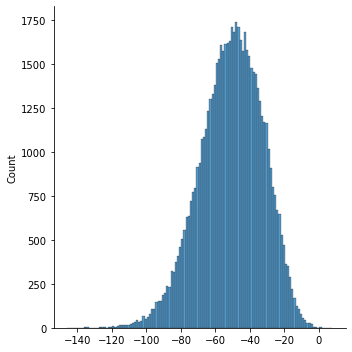

In [19]:
sns.displot(score_in)

In [23]:
out_mean = score_1.mean()
out_std = np.std(score_1, ddof=1)
print('mean:', out_mean)
print('1std:', out_mean - 1*out_std)
print('2std:', out_mean - 2*out_std)
print('3std:', out_mean - 3*out_std)
print('max', score_1.min())

mean: 67.93056
1std: 37.75620651245117
2std: 7.581855773925781
3std: -22.59249496459961
max -26.177265


In [20]:
for i in range(10):
    mis_classfied = score_in[score_in > i].shape[0]
    print('number larger than value {} : {} | accuracy:{:.6f}'.format(i, mis_classfied, (1-mis_classfied/score_in.shape[0])) )

number larger than value 0 : 6 | accuracy:0.999905
number larger than value 1 : 3 | accuracy:0.999952
number larger than value 2 : 3 | accuracy:0.999952
number larger than value 3 : 3 | accuracy:0.999952
number larger than value 4 : 2 | accuracy:0.999968
number larger than value 5 : 2 | accuracy:0.999968
number larger than value 6 : 1 | accuracy:0.999984
number larger than value 7 : 1 | accuracy:0.999984
number larger than value 8 : 0 | accuracy:1.000000
number larger than value 9 : 0 | accuracy:1.000000


In [52]:
print('max', score_in.max())
print('mean', score_in.mean())

for i in range(10):
    mis_classfied = score_in[score_in > i].shape[0]
    print('number larger than value {} : {} | accuracy:{:.6f}'.format(i, mis_classfied, (1-mis_classfied/score_in.shape[0])) )

sns.displot(score_in)

In [9]:
for i, (x, y) in enumerate(dl_ood1):
    print(i)
    out = model(x.to(device))
    score = -to_np((temperature*torch.logsumexp(out / temperature, dim=1)))
    if i == 0:
        score_1 = score
    else:
        score_1 = np.concatenate((score_1, score))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
print('mean:', score_out.mean())
print('min:', score_out.min())

for i in range(-5, 1):
    mis_classfied = score_out[score_out < -i].shape[0]
    print('number smaller than value {} : {} | accuracy:{:.6f}'.format(-i, mis_classfied, (1-mis_classfied/score_out.shape[0])) )
    

In [34]:
print('mean:', score_1.mean())
print('min:', score_1.min())

mean: 67.93056
min: -26.177265


In [25]:
for i in range(11):
    mis_classfied = score_1[score_1 < i].shape[0]
    print('number smaller than value {} : {} | accuracy:{:.6f}'.format(i, mis_classfied, (1-mis_classfied/score_1.shape[0])) )

number smaller than value 0 : 131 | accuracy:0.996725
number smaller than value 1 : 156 | accuracy:0.996100
number smaller than value 2 : 180 | accuracy:0.995500
number smaller than value 3 : 218 | accuracy:0.994550
number smaller than value 4 : 241 | accuracy:0.993975
number smaller than value 5 : 277 | accuracy:0.993075
number smaller than value 6 : 315 | accuracy:0.992125
number smaller than value 7 : 363 | accuracy:0.990925
number smaller than value 8 : 415 | accuracy:0.989625
number smaller than value 9 : 463 | accuracy:0.988425
number smaller than value 10 : 524 | accuracy:0.986900


In [23]:
for i in range(6):
    mis_classfied = score_1[score_1 < i].shape[0]
    print('number smaller than value {} : {} | accuracy:{:.6f}'.format(i, mis_classfied, (1-mis_classfied/score_1.shape[0])) )

number smaller than value 0 : 813 | accuracy:0.979674
number smaller than value 1 : 937 | accuracy:0.976574
number smaller than value 2 : 1072 | accuracy:0.973199
number smaller than value 3 : 1239 | accuracy:0.969024
number smaller than value 4 : 1442 | accuracy:0.963949
number smaller than value 5 : 1657 | accuracy:0.958574


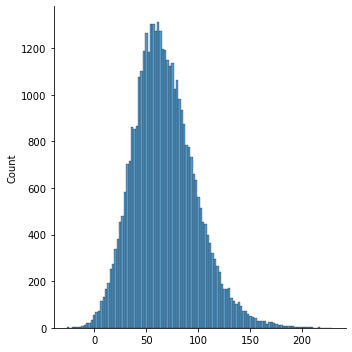

In [21]:
sns.displot(score_1)

In [51]:

for i, (x, y) in enumerate(dl_ood2):
    print(i)
    out = model(x.to(device))
    score = -to_np((temperature*torch.logsumexp(out / temperature, dim=1)))
    if i == 0:
        score_2 = score
    else:
        score_2 = np.concatenate((score_2, score))

In [18]:
import seaborn as sns
# np.save('score_1.npy', score_1)

In [53]:
# print('mean:', score_out.mean())
# print('min:', score_out.min())

# for i in range(-5, 1):
#     mis_classfied = score_out[score_out < -i].shape[0]
#     print('number smaller than value {} : {} | accuracy:{:.6f}'.format(-i, mis_classfied, (1-mis_classfied/score_out.shape[0])) )
    
# sns.displot(score_out)

In [9]:
model = t_brain_energy(0.058, 32, -5, -21, 1)
lr_logger = LearningRateMonitor()

logger = TensorBoardLogger("t_brain_energy", name="t_brain_energy")

early_stopping = EarlyStopping('val_loss', mode='min', patience=5)

model_path = 'C:/Users/bbb50/Desktop/Python/OCR/model_path/t_brain_energy'
checkpoint_callback = ModelCheckpoint(dirpath=model_path, filename= 't_brain_energy_{epoch}-{val_loss:.3f}',
                                      monitor='val_loss', mode='min', save_top_k=5)

trainer = pl.Trainer(resume_from_checkpoint='t_brain_energy_epoch=10-val_loss=0.215.ckpt',  gpus=1, limit_train_batches=0.2 ,max_epochs=100, callbacks=[lr_logger, early_stopping, checkpoint_callback], logger=logger,
       ) #gpus=1

Using cache found in C:\Users\bbb50/.cache\torch\hub\zhanghang1989_ResNeSt_master
Using cache found in C:\Users\bbb50/.cache\torch\hub\zhanghang1989_ResNeSt_master
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [10]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | classifier | Linear     | 1.6 M 
1 | seq_1      | Sequential | 28.6 K
2 | seq_2      | Sequential | 9.3 M 
3 | seq_3      | Sequential | 16.2 M
------------------------------------------
27.1 M    Trainable params
0         Non-trainable params
27.1 M    Total params
108.294   Total estimated model params size (MB)
Restored states from the checkpoint file at t_brain_energy_epoch=10-val_loss=0.215.ckpt


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]